In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import json
import os
import glob

data_folder_path = '/content/drive/My Drive/JSON'
file_pattern = 'bank_0.json'

# 3. Script to Load and Parse Data
print(f"\nSearching for files matching '{file_pattern}' in: {data_folder_path}")

search_path = os.path.join(data_folder_path, file_pattern)
json_file_paths = glob.glob(search_path)

if not json_file_paths:
    print(f"Error: No files found at '{search_path}'.")
    print("Please check that your 'bank_*.json' files are in the main 'My Drive' folder.")
else:
    print(f"Found {len(json_file_paths)} files: {json_file_paths}")

    all_records = []

    # Loop through each found JSON file
    for file_path in json_file_paths:
        print(f"\nProcessing file: {os.path.basename(file_path)}...")
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                # Extract the list of transactions from the 'records' key
                records_in_file = data['records']
                # Add all records from this file to our main list
                all_records.extend(records_in_file)
                print(f"  - Successfully extracted {len(records_in_file)} records.")

        except Exception as e:
            print(f"  - An error occurred while processing {os.path.basename(file_path)}: {e}")

    # Proceed only if records were found
    if all_records:
        print("\nCombining all records into a Pandas DataFrame...")

        # Convert the list of dictionaries into a DataFrame
        df = pd.DataFrame(all_records)

        print("DataFrame created successfully!")
        print("\n--- DataFrame Info ---")
        df.info()

        print("\n--- DataFrame Head (First 5 Rows) ---")
        print(df.head())
    else:
        print("\nNo records were loaded, cannot create DataFrame.")


Searching for files matching 'bank_0.json' in: /content/drive/My Drive/JSON
Found 1 files: ['/content/drive/My Drive/JSON/bank_0.json']

Processing file: bank_0.json...
  - Successfully extracted 692417 records.

Combining all records into a Pandas DataFrame...
DataFrame created successfully!

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692417 entries, 0 to 692416
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Timestamp             692417 non-null  object 
 1   From Bank             692417 non-null  int64  
 2   From_Account          692417 non-null  object 
 3   To Bank               692417 non-null  int64  
 4   To_Account            692417 non-null  object 
 5   Amount Received       692417 non-null  float64
 6   Receiving Currency    692417 non-null  object 
 7   Amount Paid           692417 non-null  float64
 8   Payment Currency      692417 non-null  object

Feature Engineering

In [ ]:
import pandas as pd
import numpy as np

print("Starting feature engineering...")
# Create a copy to avoid changing the original DataFrame
df_processed = df.copy()

# 1. Time-based Feature Engineering
# Convert 'Timestamp' to datetime object
df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'])

# Extract time features
df_processed['Hour'] = df_processed['Timestamp'].dt.hour
df_processed['DayOfWeek'] = df_processed['Timestamp'].dt.dayofweek
df_processed['IsWeekend'] = df_processed['DayOfWeek'].isin([5, 6]).astype(int)
df_processed['IsNightTime'] = ((df_processed['Hour'] >= 22) | (df_processed['Hour'] <= 6)).astype(int)

# --- 2. Relational Feature Engineering ---
df_processed['Same_Bank'] = (df_processed['From Bank'] == df_processed['To Bank']).astype(int)
df_processed['Same_Account'] = (df_processed['From_Account'] == df_processed['To_Account']).astype(int)

# --- 3. Currency Feature Engineering ---
df_processed['Currency_Mismatch'] = (df_processed['Receiving Currency'] != df_processed['Payment Currency']).astype(int)

# --- 4. Amount-based Feature Engineering ---
# Use np.log1p for numerical stability (handles zeros)
df_processed['Log_Amount_Received'] = np.log1p(df_processed['Amount Received'])
df_processed['Log_Amount_Paid'] = np.log1p(df_processed['Amount Paid'])

# Feature for transactions just below common reporting thresholds (e.g., $10,000)
df_processed['Below_Threshold'] = ((df_processed['Amount Received'] > 9000) & (df_processed['Amount Received'] < 10000)).astype(int)

# --- 5. Categorical Feature Encoding ---
# One-hot encode 'Payment Format'
df_processed = pd.get_dummies(df_processed, columns=['Payment Format'], prefix='Format', drop_first=True)

print("✓ Feature engineering complete!")

# --- 6. Define Final Features (X) and Target (y) ---
# This is the full list of features your model expects
feature_columns = [
    'Hour', 'DayOfWeek', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account',
    'Currency_Mismatch', 'Log_Amount_Received', 'Log_Amount_Paid', 'Below_Threshold'
]

# Add the new one-hot encoded 'Format_' columns to the list
format_columns = [col for col in df_processed.columns if 'Format_' in col]
feature_columns.extend(format_columns)

# Create the final X and y
X = df_processed[feature_columns]
y = df_processed['Is Laundering']

print(f"\nCreated {len(feature_columns)} features.")
print("\n--- Features (X) after preprocessing (first 5 rows): ---")
print(X.head())

print("\n--- Target (y) (first 5 rows): ---")
print(y.head())


Starting feature engineering...
✓ Feature engineering complete!

Created 16 features.

--- Features (X) after preprocessing (first 5 rows): ---
   Hour  DayOfWeek  IsWeekend  IsNightTime  Same_Bank  Same_Account  \
0    18          3          0            0          0             0   
1    19          4          0            0          0             0   
2    18          2          0            0          0             0   
3     3          3          0            1          1             1   
4    21          4          0            0          0             0   

   Currency_Mismatch  Log_Amount_Received  Log_Amount_Paid  Below_Threshold  \
0                  0             6.633818         6.633818                0   
1                  0             7.035647         7.035647                0   
2                  0             8.001151         8.001151                0   
3                  0             9.980921         9.980921                0   
4                  0             0

Exploratory Data Analysis


Creating visualizations for Exploratory Data Analysis...


/tmp/ipython-input-41483162.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Different Bank', 'Same Bank'])
/tmp/ipython-input-41483162.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Day', 'Night'])
/tmp/ipython-input-41483162.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 2].set_xticklabels(['No', 'Yes'])


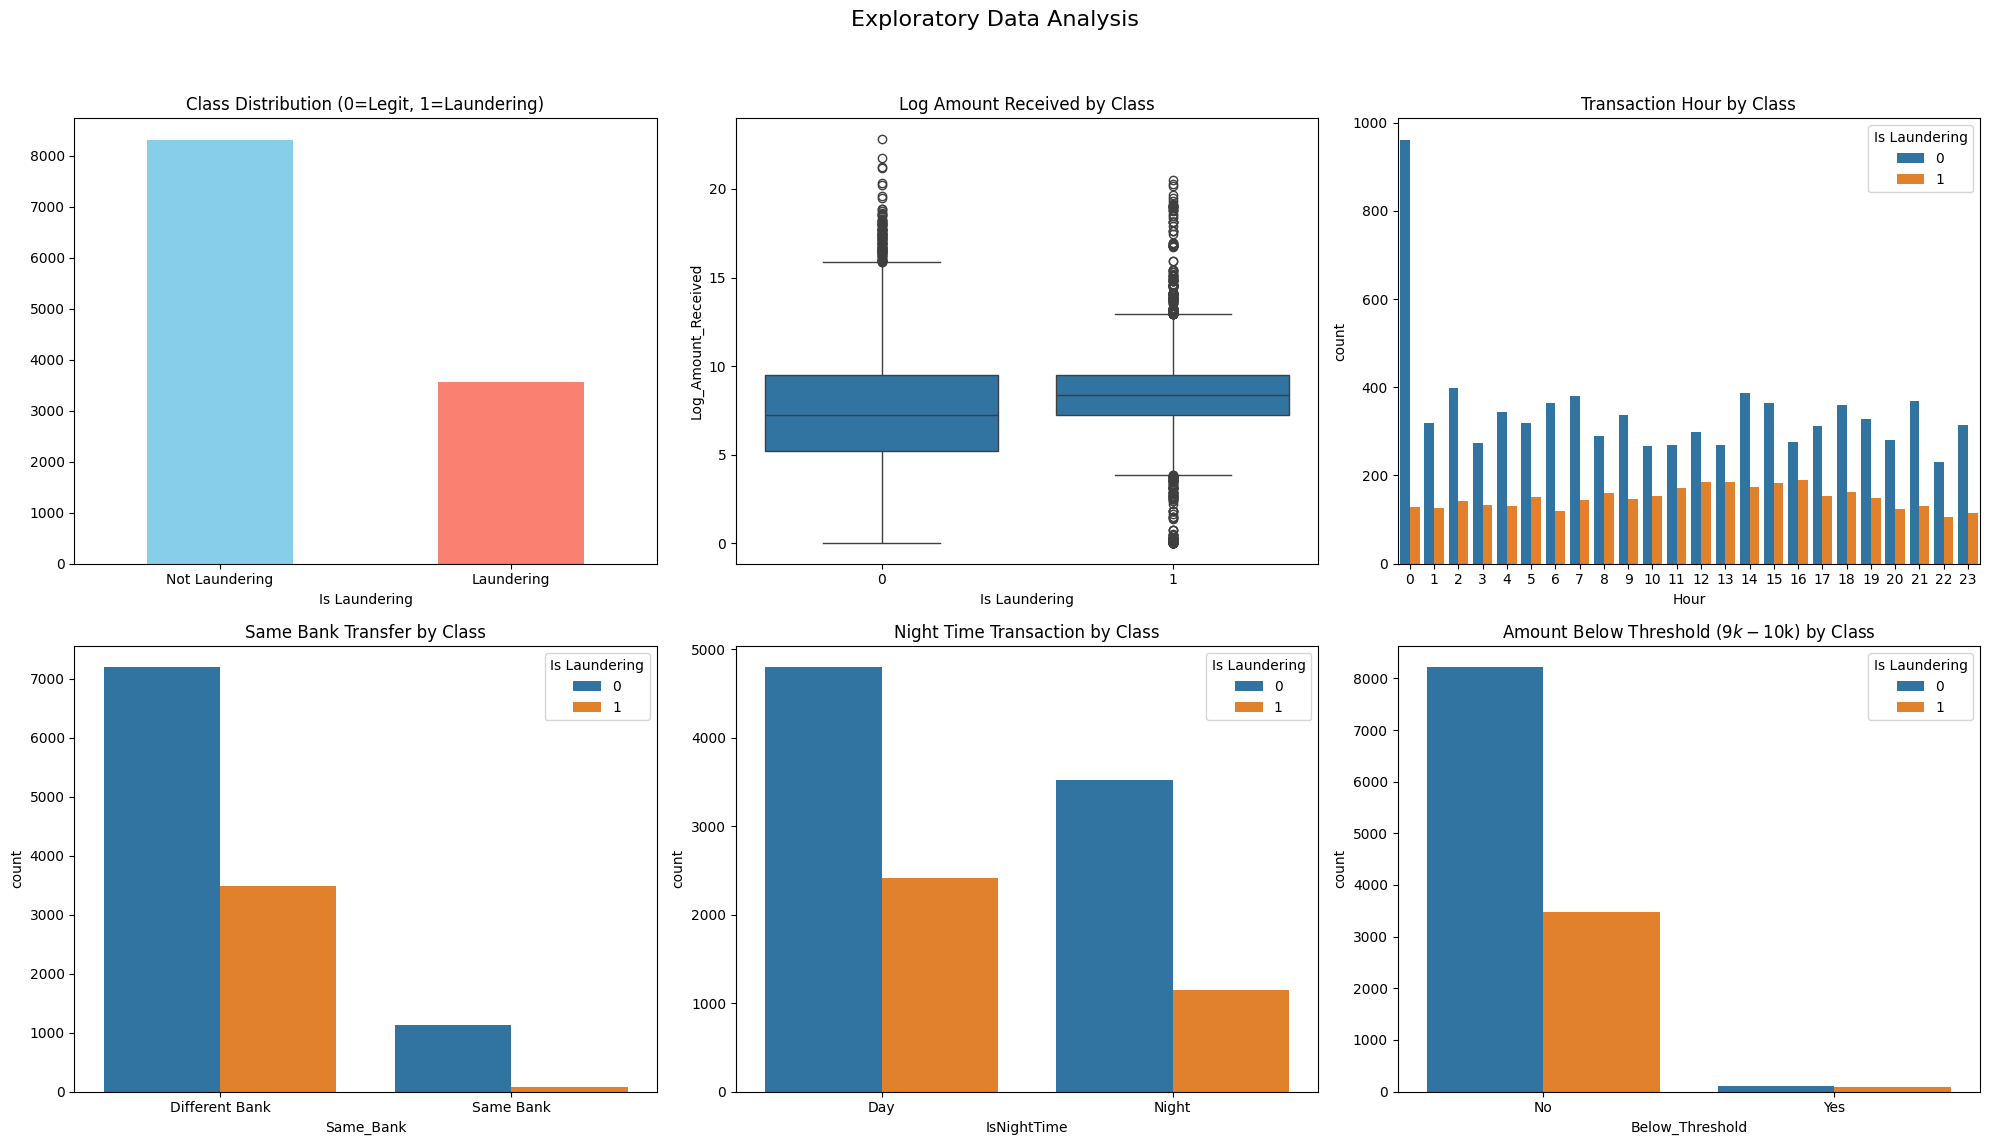

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nCreating visualizations for Exploratory Data Analysis...")
sample_df = df_processed.sample(n=min(500000, len(df_processed)), random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Exploratory Data Analysis', fontsize=16)

# 1. Class distribution (shows the imbalance)
sample_df['Is Laundering'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'salmon'])
axes[0, 0].set_title('Class Distribution (0=Legit, 1=Laundering)')
axes[0, 0].set_xticklabels(['Not Laundering', 'Laundering'], rotation=0)

# 2. Log amount distribution by class
sns.boxplot(x='Is Laundering', y='Log_Amount_Received', data=sample_df, ax=axes[0, 1])
axes[0, 1].set_title('Log Amount Received by Class')

# 3. Transaction hour distribution by class
sns.countplot(x='Hour', hue='Is Laundering', data=sample_df, ax=axes[0, 2])
axes[0, 2].set_title('Transaction Hour by Class')

# 4. Same bank transactions by class
sns.countplot(x='Same_Bank', hue='Is Laundering', data=sample_df, ax=axes[1, 0])
axes[1, 0].set_title('Same Bank Transfer by Class')
axes[1, 0].set_xticklabels(['Different Bank', 'Same Bank'])

# 5. Night time transactions by class
sns.countplot(x='IsNightTime', hue='Is Laundering', data=sample_df, ax=axes[1, 1])
axes[1, 1].set_title('Night Time Transaction by Class')
axes[1, 1].set_xticklabels(['Day', 'Night'])

# 6. Transactions just below the reporting threshold
sns.countplot(x='Below_Threshold', hue='Is Laundering', data=sample_df, ax=axes[1, 2])
axes[1, 2].set_title('Amount Below Threshold ($9k-$10k) by Class')
axes[1, 2].set_xticklabels(['No', 'Yes'])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Model Training

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

print("\n--- Starting Model Training ---")

# 1. Split and Scale Data
print("Splitting and scaling data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Build and Compile the Model
print("Building Keras model...")
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4), # Reduced dropout
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2), # Reduced dropout
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile with a slightly faster learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Increased LR
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model.summary()

# 3. Define Early Stopping
# This stops training when validation loss stops improving and restores the best model weights.
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 4. Train the Model
print("\nTraining model (with Early Stopping)...")
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100, # Increased max epochs
    batch_size=2048,
    callbacks=[early_stopping_cb],
    verbose=1
)
print("--- Model Training Complete ---")

# 5. Evaluate the Model
print("\n--- Evaluating Model on Test Set (using best weights) ---")
loss, accuracy, recall = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall:   {recall:.4f}")

print("\nEvaluation complete. 'history' object is available for plotting.")


--- Starting Model Training ---
Splitting and scaling data...
Building Keras model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 192 (768.00 B)


Training model (with Early Stopping)...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 710ms/step - accuracy: 0.5417 - loss: 0.8269 - recall: 0.6327 - val_accuracy: 0.6856 - val_loss: 0.6137 - val_recall: 0.4881
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6042 - loss: 0.7226 - recall: 0.7196 - val_accuracy: 0.7664 - val_loss: 0.6000 - val_recall: 0.5666
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6516 - loss: 0.6524 - recall: 0.7454 - val_accuracy: 0.7900 - val_loss: 0.5864 - val_recall: 0.5835
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6874 - loss: 0.6122 - recall: 0.7640 - val_accuracy: 0.8085 - val_loss: 0.5720 - val_recall: 0.6185
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7199 - loss: 0.5705 - recall: 0.7657 - val_accuracy: 0.8157 - val_loss: 0.5576 - val_recall: 0.6325
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7375 - loss: 0.5519 - recall: 0.7791 - val_accuracy: 0.8232 - val_loss: 0.

Plotting and analysis

--- Plotting Model Accuracy and Loss ---


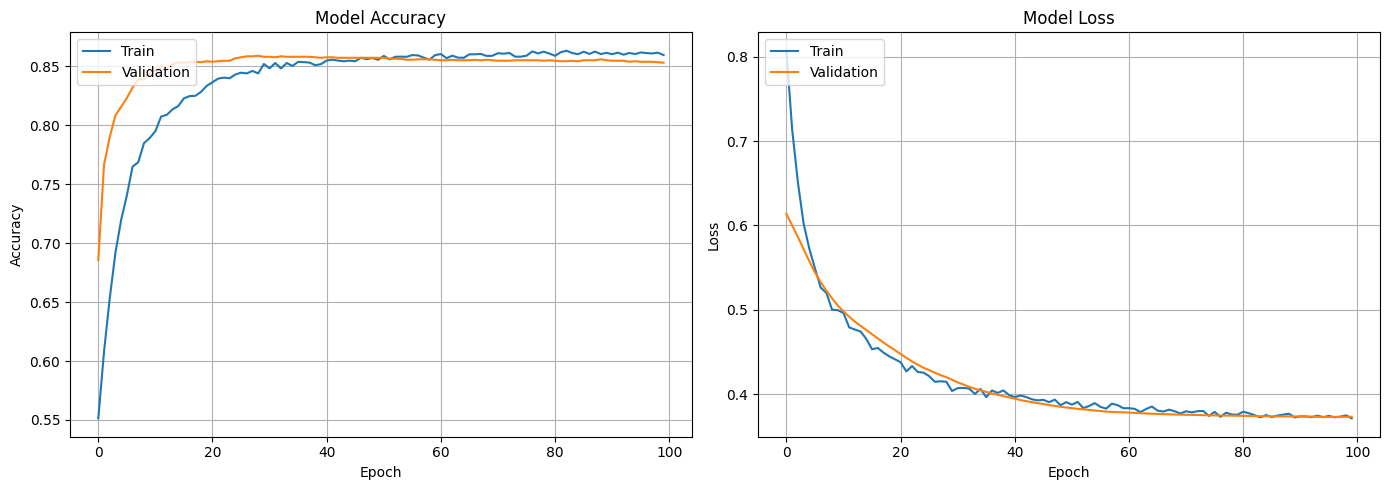


--- Generating Confusion Matrix ---
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


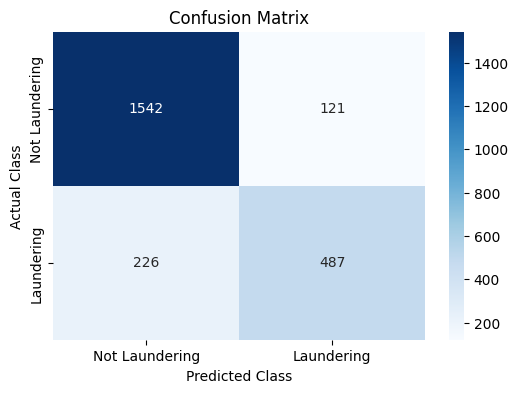


--- Classification Report ---
                precision    recall  f1-score   support

Not Laundering       0.87      0.93      0.90      1663
    Laundering       0.80      0.68      0.74       713

      accuracy                           0.85      2376
     macro avg       0.84      0.81      0.82      2376
  weighted avg       0.85      0.85      0.85      2376



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1. Plot Training & Validation Accuracy and Loss
print("--- Plotting Model Accuracy and Loss ---")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

# Save the figure and show the plot
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


# --- 2. Generate Predictions and Confusion Matrix ---
print("\n--- Generating Confusion Matrix ---")
y_pred_probabilities = model.predict(X_test_scaled)
y_pred_classes = (y_pred_probabilities > 0.5).astype(int).flatten()

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Laundering', 'Laundering'],
            yticklabels=['Not Laundering', 'Laundering'])

plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig('confusion_matrix.png')
plt.show()


# 3. Print Classification Report
print("\n--- Classification Report ---")
# This report provides precision, recall, f1-score, and support
report = classification_report(y_test, y_pred_classes, target_names=['Not Laundering', 'Laundering'])
print(report)